In [1]:
import xarray as xr
import matplotlib.pyplot as plt

from radially_constrained_cluster import *

In [2]:
dataset_t2m = xr.open_mfdataset(r'C:\Users\ITJG104327\Documents\Venezia\Dataset\to_seas\2m_temperature/*.nc').rolling(time=20*24).mean()
dataset_tp = xr.open_mfdataset(r'C:\Users\ITJG104327\Documents\Venezia\Dataset\to_seas\total_precipitation/*.nc').rolling(time=20*24).mean()

In [3]:
dataset_t2m = dataset_t2m.sel(latitude=slice(46, 45), longitude=slice(11, 12))
dataset_t2m = dataset_t2m.groupby('time.dayofyear').mean()

In [4]:
dataset_tp = dataset_tp.sel(latitude=slice(46, 45), longitude=slice(11, 12))
dataset_tp = dataset_tp.groupby('time.dayofyear').mean()

In [5]:
array_t2m = dataset_t2m.t2m.to_numpy()
array_t2m = np.reshape(array_t2m, (array_t2m.shape[0], array_t2m.shape[1]*array_t2m.shape[2]))

In [6]:
array_tp = dataset_tp.tp.to_numpy()
array_tp = np.reshape(array_tp, (array_tp.shape[0], array_tp.shape[1]*array_tp.shape[2]))

In [7]:
# concatenate the two arrays on columns
array_tot = np.concatenate((array_t2m, array_tp), axis=1)

In [8]:
# min-max normalization on axis 1
array_tot = (array_tot - array_tot.min(axis=1).reshape(-1, 1)) / (array_tot.max(axis=1) - array_tot.min(axis=1)).reshape(-1, 1)

Text(0, 0.5, 'Within-Cluster Sum of Square')

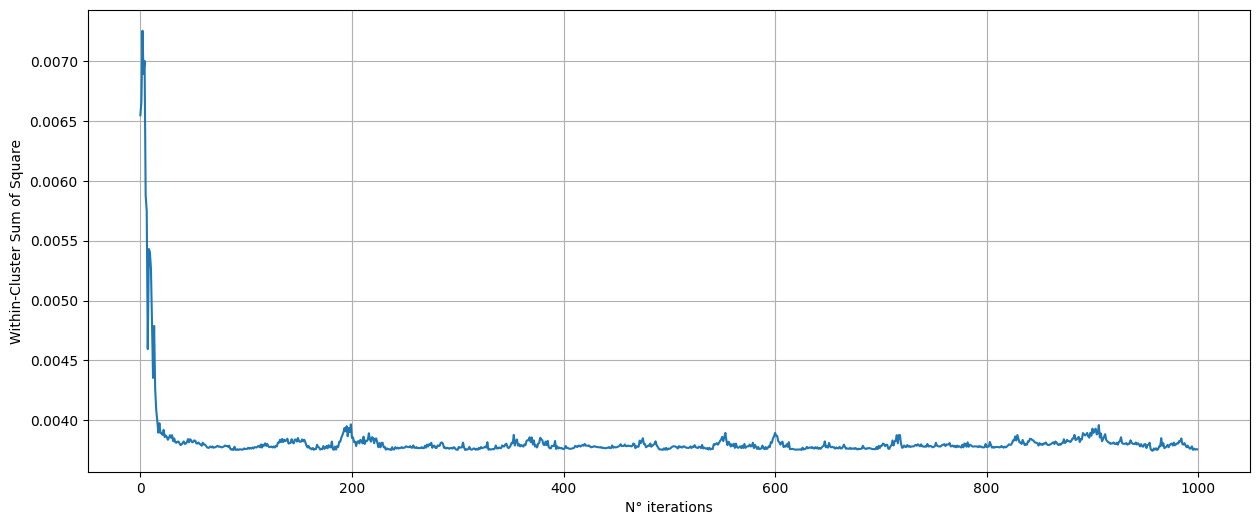

In [15]:
model = Radially_Constrained_Cluster(data_to_cluster = array_tot,
                                     n_seas = 4,
                                     n_iter = 1000,
                                     learning_rate = 10,
                                     scheduling_factor = 1.0000000001,
                                     min_len=30,
                                     mode = 'single')

model.fit()
prediction = model.get_prediction()

fig_learning = plt.figure(figsize = (15,6))
plt.plot(model.error_history)
plt.grid()
plt.xlabel('N° iterations')
plt.ylabel('Within-Cluster Sum of Square')

In [16]:
cc = model.get_centroids()  
bb = model.breakpoints

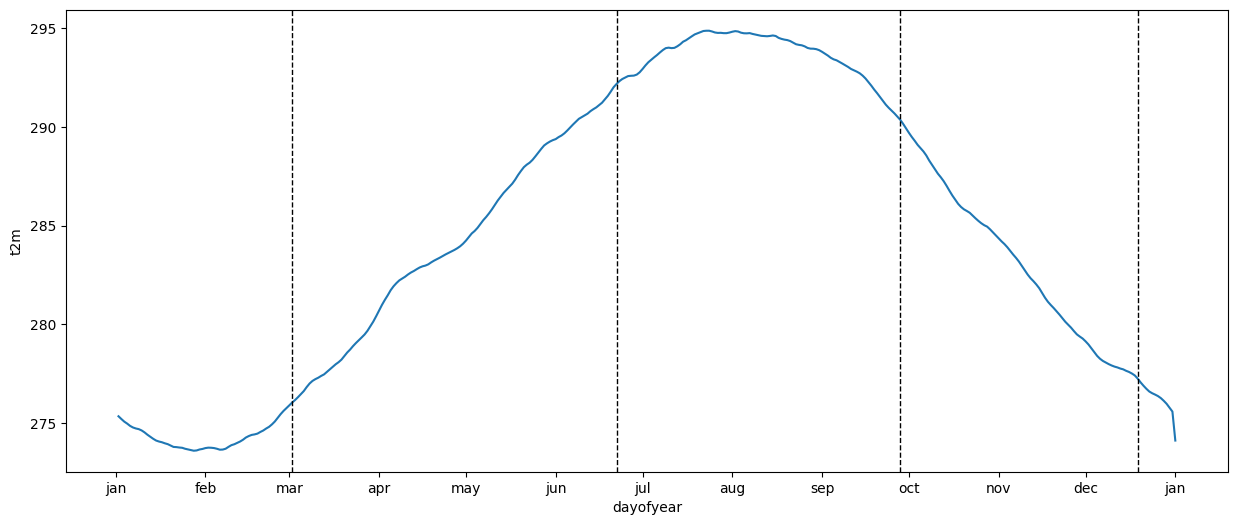

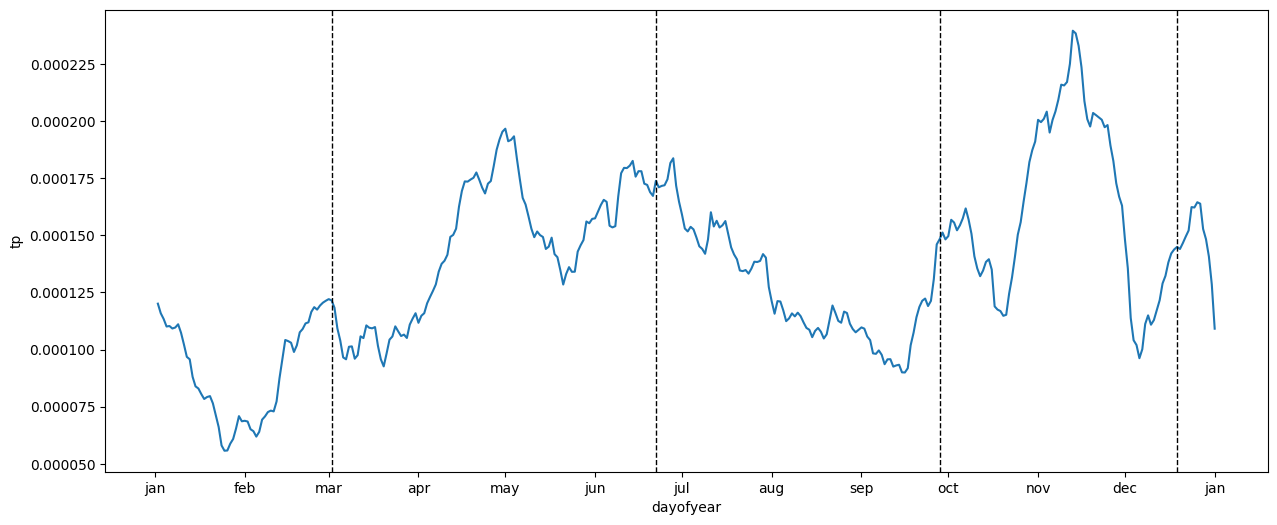

In [17]:
fig_clustered_field, ax = plt.subplots(figsize = (15,6))

dataset_t2m.t2m.mean(['latitude', 'longitude']).plot(ax=ax)
for b in bb:
    ax.axvline(b, color='k', linestyle='--', linewidth=1)

ax.set_xticks([0,31,60,91,121,152,182,213,244,274,305,335,366],['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec','jan'])

fig_clustered_field, ax = plt.subplots(figsize = (15,6))

dataset_tp.tp.mean(['latitude', 'longitude']).plot(ax=ax)
for b in bb:
    ax.axvline(b, color='k', linestyle='--', linewidth=1)

ax.set_xticks([0,31,60,91,121,152,182,213,244,274,305,335,366],['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec','jan'])

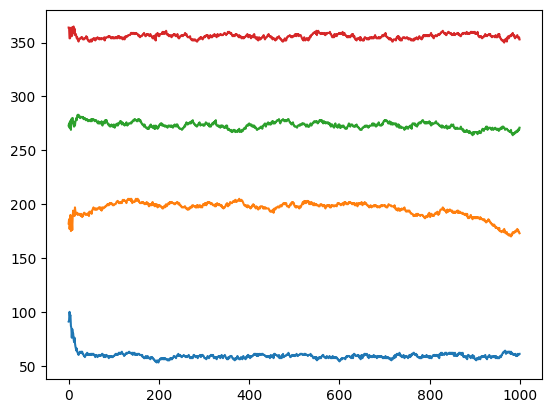

In [18]:
for j in range(4):
    plt.plot(np.array(model.breakpoint_history)[:,j])

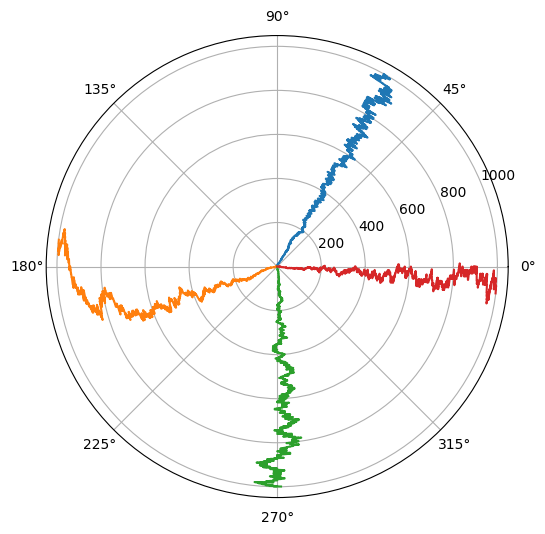

In [19]:
arr = np.array(model.breakpoint_history)
r = np.arange(0,len(arr[:,0]))

fig, ax = plt.subplots(figsize = (6,6),subplot_kw={'projection': 'polar'})

for j in range(4):

    arr = np.array(model.breakpoint_history)[:,j]
    theta = arr * (np.pi / 180.)
    ax.plot(theta, r)

    
#ax.set_rmax(2)
#ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

In [20]:
cc_story = np.mean(model.centroid_story[:,:,30:50],axis=2)

for j in range(4):
    plt.plot(np.array(cc_story)[:,j])

AttributeError: 'Radially_Constrained_Cluster' object has no attribute 'centroid_story'